In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [2]:
# Open CAPE data
cape_1940s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')['CAPE'][184*10:]
cape_1950s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1950s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19500101-19591231.nc')['CAPE'][184*10:]
cape_1960s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1960s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19600101-19691231.nc')['CAPE'][184*10:]
cape_1970s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1970s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19700101-19791231.nc')['CAPE'][184*10:]
cape_1980s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1980s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19800101-19891231.nc')['CAPE']
cape_1990s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1990s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19900101-19991231.nc')['CAPE']
cape_2000s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/2000s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20000101-20091231.nc')['CAPE']
cape_2010s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/2010s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20100101-20191231.nc')['CAPE']
cape_2020s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/2020s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20200101-20241130.nc')['CAPE']

In [3]:
# Select the CONUS only
cape_1940s_conus = cape_1940s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1950s_conus = cape_1950s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1960s_conus = cape_1960s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1970s_conus = cape_1970s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1980s_conus = cape_1980s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1990s_conus = cape_1990s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2000s_conus = cape_2000s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2010s_conus = cape_2010s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2020s_conus = cape_2020s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [4]:
# Concatenate time periods
cape_conus = xr.concat([cape_1940s_conus, cape_1950s_conus, cape_1960s_conus, cape_1970s_conus, cape_1980s_conus, \
                        cape_1990s_conus, cape_2000s_conus, cape_2010s_conus, cape_2020s_conus], dim='time')

In [80]:
# Select MAM and resample to seasonal means
cape_conus_mam = cape_conus.sel(time=cape_conus.time.dt.month.isin([3, 4, 5])).resample(time='1Y').mean().dropna(dim='time')

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [81]:
def detrend_dim(da, dim, deg):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [82]:
# degree 2 polynomial detrend
cape_conus_mam_detrend = detrend_dim(cape_conus_mam, 'time', 2)

In [83]:
# Remove the seasonal cycle
cape_conus_mam_anoms = cape_conus_mam_detrend.groupby('time.month') - cape_conus_mam_detrend.groupby('time.month').mean()

In [84]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [85]:
# Standardize Nino3.4
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [86]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM and take seasonal averages
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='1Y').mean()
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='1Y').mean()

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [87]:
# Regress the PDO on ENSO
# Add constant for intercept
X = sm.add_constant(nino_34_1940_2024_mam.dropna(dim='time').values)
model = sm.OLS(pdo_1940_2024_mam.dropna(dim='time').values, X).fit()

# Get residuals (PDO after removing ENSO influence)
pdo_resid = model.resid

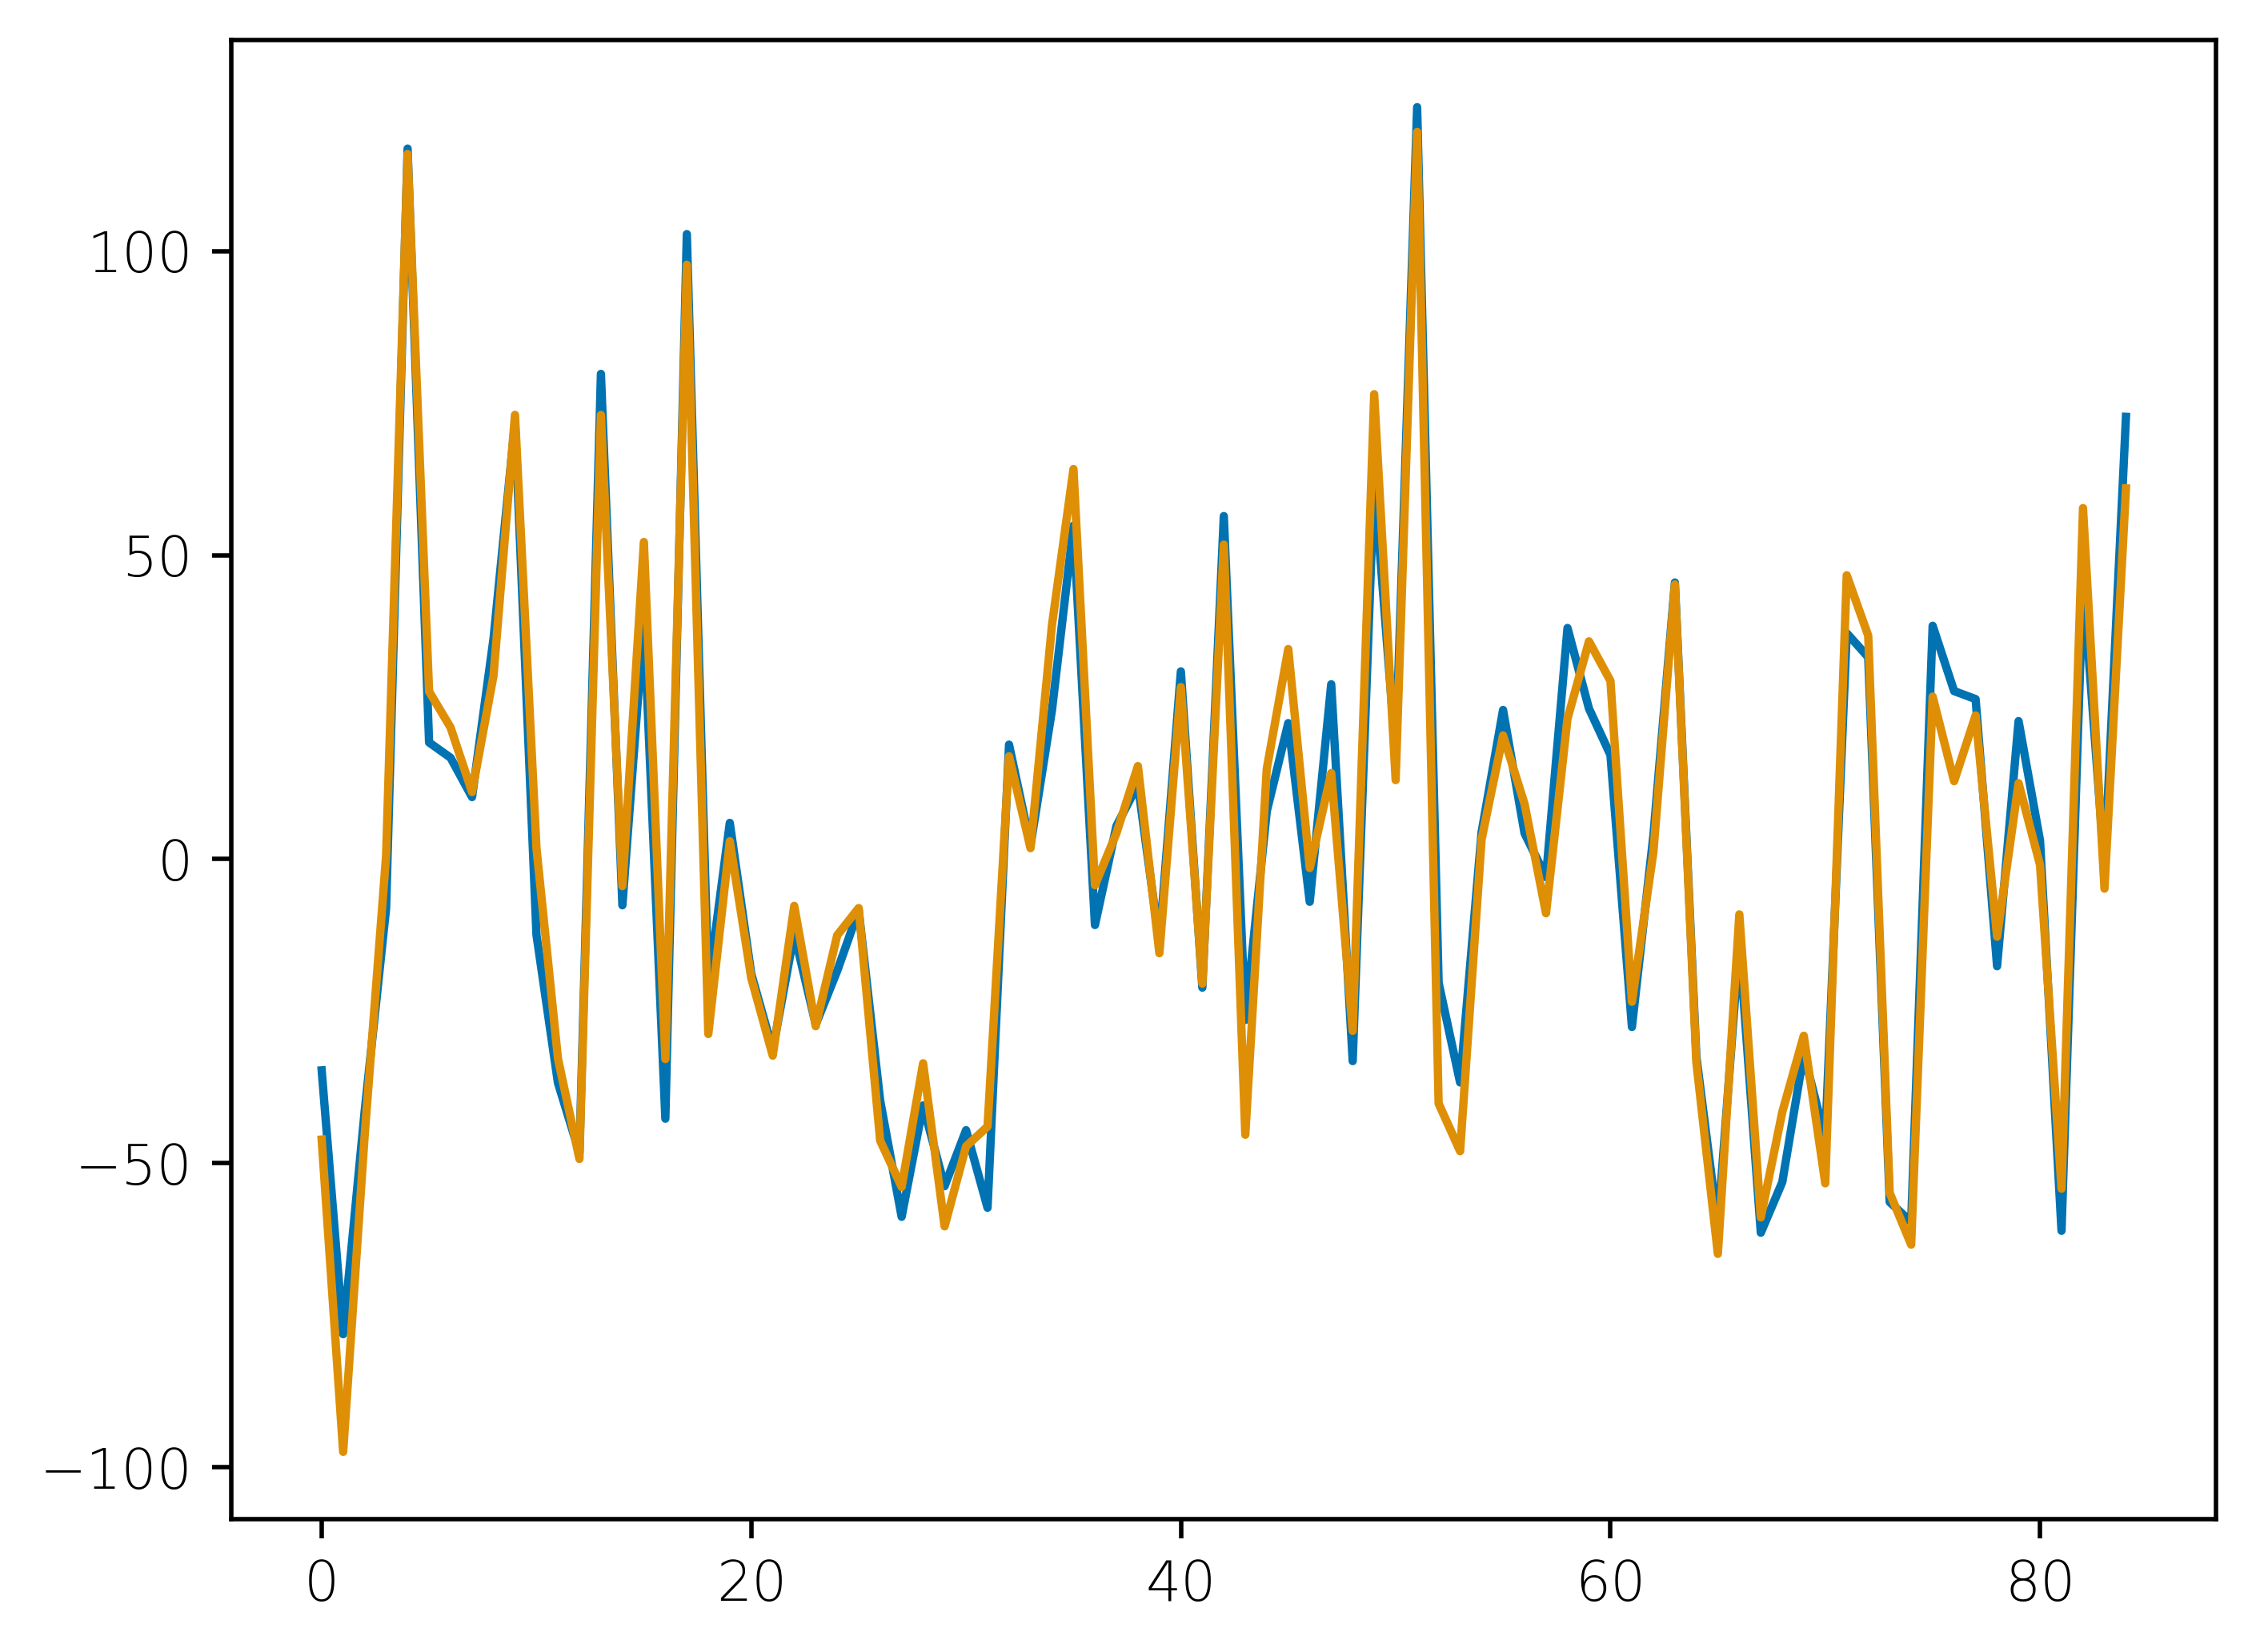

In [90]:
plt.plot(np.mean(cape_resid, axis=(1, 2)))
plt.plot(cape_conus_mam_anoms.mean(dim=('latitude', 'longitude')))

In [89]:
# Remove the influence of ENSO from CAPE
time_len, lat_len, lon_len = cape_conus_mam_anoms.shape

cape_resid = np.full((time_len, lat_len, lon_len), np.nan)

for i in range(lat_len):
    for j in range(lon_len):
        y = cape_conus_mam_anoms.values[:, i, j]
        if np.all(np.isfinite(y)):
            model = sm.OLS(y, X).fit()
            cape_resid[:, i, j] = model.resid

    print(f'latitude {i+1} out of {lat_len} is complete.')

latitude 1 out of 101 is complete.
latitude 2 out of 101 is complete.
latitude 3 out of 101 is complete.
latitude 4 out of 101 is complete.
latitude 5 out of 101 is complete.
latitude 6 out of 101 is complete.
latitude 7 out of 101 is complete.
latitude 8 out of 101 is complete.
latitude 9 out of 101 is complete.
latitude 10 out of 101 is complete.
latitude 11 out of 101 is complete.
latitude 12 out of 101 is complete.
latitude 13 out of 101 is complete.
latitude 14 out of 101 is complete.
latitude 15 out of 101 is complete.
latitude 16 out of 101 is complete.
latitude 17 out of 101 is complete.
latitude 18 out of 101 is complete.
latitude 19 out of 101 is complete.
latitude 20 out of 101 is complete.
latitude 21 out of 101 is complete.
latitude 22 out of 101 is complete.
latitude 23 out of 101 is complete.
latitude 24 out of 101 is complete.
latitude 25 out of 101 is complete.
latitude 26 out of 101 is complete.
latitude 27 out of 101 is complete.
latitude 28 out of 101 is complete.
l

In [91]:
pdo_reg_no_enso_corr, pdo_reg_no_enso_coef = pdo_functions.linregress_3D(pdo_resid, cape_resid)[1:3]

In [92]:
test_coef = pdo_functions.linregress_3D(pdo_resid, cape_conus_mam_anoms)[2]

In [100]:
# Calculating the t-statistic
pdo_no_enso_t = pdo_reg_no_enso_corr * ((85-2)**0.5) / ((1-pdo_reg_no_enso_corr **2)**0.5)

In [101]:
# Calculating the p-values
pdo_no_enso_p = 2 * (1-scipy.stats.t.cdf(abs(pdo_no_enso_t), 85-2))

In [102]:
# Calculating adjusted p-values to account for the False Discovery Rate
pdo_no_enso_adj_p = pdo_functions.control_FDR(pdo_no_enso_p, 101, 237)

In [106]:
pdo_sig = np.where(pdo_no_enso_p < pdo_no_enso_adj_p, 3, 0)

In [111]:
np.shape(cape_resid)

(85, 101, 237)

Text(0.5, 1.0, 'percent variance explained')

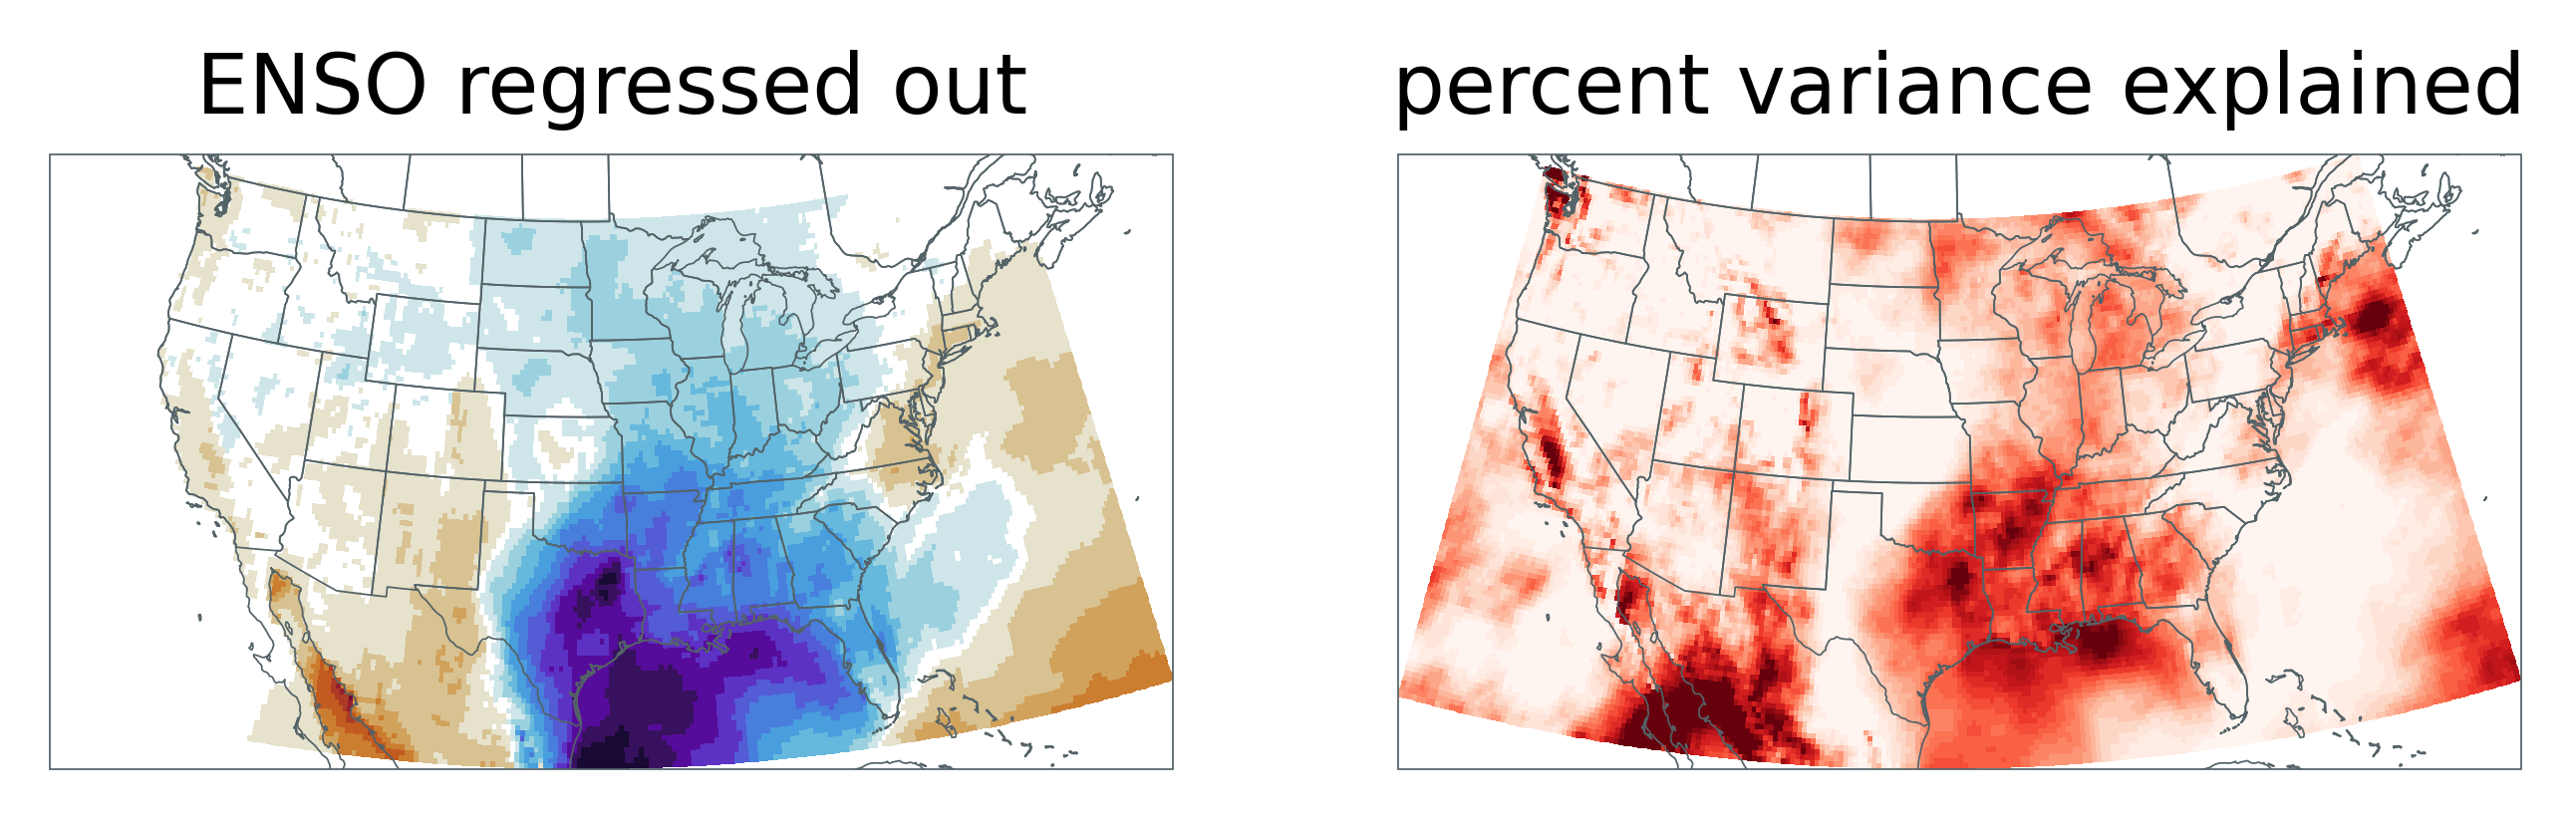

In [109]:
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

bounds = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, -2.5, 2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

corr_bounds = np.arange(0, 10.5, 0.5)

norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

corr_norm = c.BoundaryNorm(corr_bounds, plt.get_cmap("Reds").N)

for i in range(2):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)

ax[0].pcolormesh(cape_conus['longitude'], cape_conus['latitude'], pdo_reg_no_enso_coef, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=norm)

ax[1].pcolormesh(cape_conus['longitude'], cape_conus['latitude'], (pdo_reg_no_enso_corr**2)*100, transform=ccrs.PlateCarree(), cmap='Reds', norm=corr_norm)

ax[0].contourf(cape_conus['longitude'], cape_conus['latitude'], pdo_sig, transform=ccrs.PlateCarree(), hatches=[None, '\\\\\\\\\\\\\\\\\\'], colors=None, alpha=0)

ax[0].set_title('ENSO regressed out')
ax[i].set_title('percent variance explained')